   This is a project that I have been working on in my free time and is an extension of a previous car related project. The data is collected from an Arduino data-logger connected to my car. Each time the logger gets a batch of information from the car's computer or the gps receiver, it writes the time since the car started followed by a data code and a value.

   The car takes time to send new data so there is a mismatch between the times on the car data and the gps data. I decided to split the data into car data from the OBDII port and gps sourced data. Another issue that I ran into is that the accelerometer also reports data more often than the OBDII port and at different intervals than the gps data.
   
   My plan is to split the data into three sets. One for the OBDII car data, one for the gps data, and one for the acceleration data. Then, I can use each separately. 
   
   First, I'll walk through my process for separating the data. Then, I will clean up the data and do some unit conversions. Finally, I will plot some location data to get an idea for what is possible.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Each filename begins with the month followed by the day. Files do not have metadata so the creation dates are all the same. I will use the UTC data and time from the gps data to rename the files later.

In [2]:
df = pd.read_csv('raw_data/11191815.CSV',header=None)
df.columns = ['time','code','value']

I have read in the file and assigned my own column names. The code column contains a repeating set of codes for a given time index. I would like to make new columns for each code and have one column for each unique time. Then, the code values need to fall under the right column.

In [3]:
df

,time,code,value
0,59851,10C,902
1,59851,20,0;-1;-1
2,59851,10D,0
3,59851,20,0;0;0
4,59851,111,17
...,...,...,...
271849,5201731,F,12
271850,5201734,20,-5;3;0
271851,5201734,20,-4;2;0
271852,5201734,20,-5;3;0


I start by making a list of the unique times in the time column. Then, I make new dataframes for the code data and acceleration data because they occur at different frequencies.


In [4]:
times_list = df['time'].unique()

In [5]:
len(times_list)

35894

In [6]:
df['code'].unique()

array(['10C', '20', '10D', '111', '104', '24', '11', '10', 'A', 'B', 'C',
       'D', 'F'], dtype=object)

Code 20's indicate accelerometer data and that data goes to a separate dataframe.|

In [7]:
codes = pd.DataFrame(index=times_list,columns=['10C', '10D', '111', '104', '24', '11', '10', 'A', 'B', 'C',
       'D', 'F'])
codes

acc = pd.DataFrame(index=times_list,columns=['acc1','acc2','acc3','acc4'])
acc

,acc1,acc2,acc3,acc4
59851,NaN,NaN,NaN,NaN
64487,NaN,NaN,NaN,NaN
64490,NaN,NaN,NaN,NaN
64751,NaN,NaN,NaN,NaN
64754,NaN,NaN,NaN,NaN
...,...,...,...,...
5201052,NaN,NaN,NaN,NaN
5201318,NaN,NaN,NaN,NaN
5201321,NaN,NaN,NaN,NaN
5201731,NaN,NaN,NaN,NaN


Here is a full set of data returned from the OBDII port. Notice how often code 20 shows up.

In [8]:
df.loc[df['time'] == times_list[0]]

,time,code,value
0,59851,10C,902
1,59851,20,0;-1;-1
2,59851,10D,0
3,59851,20,0;0;0
4,59851,111,17
5,59851,20,0;0;0
6,59851,104,27
7,59851,20,0;1;0
8,59851,24,1463


In [9]:
from tqdm.notebook import tqdm_notebook
import time

This function iterates through the list of unique times. Then, looks at the data at that time. If the code is 20, the value is acceleration data and gets put in that dataframe. Everything else gets put in the codes dataframe.

In [10]:
def first_process(df,times_list,codes,acc):

    for time in tqdm_notebook(times_list):

        accel = 1
        timedf = df.loc[df['time'] == time].copy().reset_index()
        for row, val in enumerate(timedf['code']):

            if val == '20':
                #put in other dataframe
                acc['acc' + str(accel)][time] = timedf['value'][row]
                accel = accel + 1
            else:
                codes[val][time] = timedf['value'][row]
                
    return df, times_list, codes, acc

In [11]:
df, times_list, codes, acc = first_process(df,times_list,codes,acc)

  0%|          | 0/35894 [00:00<?, ?it/s]

In [12]:
conv_codes = codes
conv_acc = acc

Some of the data are NaN because that data was not returned for that time. For the first time, car data from the OBDII data is returned, but no the gps data. Then, the next time includes gps data and not the car's OBDII data.

In [13]:
conv_codes

,10C,10D,111,104,24,11,10,A,B,C,D,F
59851,902,0,17,27,1463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64487,NaN,NaN,NaN,NaN,NaN,191121,18152140,33464435,-86723838,184,377,4
64490,908,0,16,27,1463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64751,NaN,NaN,NaN,NaN,NaN,NaN,18152160,33464435,-86723836,184,323,4
64754,909,0,16,27,1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5201052,0,0,32,0,1231,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5201318,NaN,NaN,NaN,NaN,NaN,NaN,19405710,34075533,-87163657,184,107,12
5201321,0,0,32,NaN,1231,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5201731,NaN,NaN,NaN,NaN,NaN,NaN,19405750,34075533,-87163657,184,53,12


Here is the acceleration data. The NaNs are times where gps data was returned and not OBDII data.

In [14]:
conv_acc

,acc1,acc2,acc3,acc4
59851,0;-1;-1,0;0;0,0;0;0,0;1;0
64487,NaN,NaN,NaN,NaN
64490,0;-1;-2,-2;0;0,0;-1;0,0;0;0
64751,NaN,NaN,NaN,NaN
64754,0;0;-1,0;0;0,0;0;0,0;1;0
...,...,...,...,...
5201052,-5;2;-1,-5;2;0,-4;2;-1,-5;3;-2
5201318,NaN,NaN,NaN,NaN
5201321,-5;2;0,-4;2;0,-4;2;-2,-5;4;-1
5201731,NaN,NaN,NaN,NaN


I used a dictionary map to rename the columns from the codes to what they actually represent. 

Here is what the Freematics site says for the data:


    0x104 – Engine load
    0x105 – Engine coolant temperature
    0x10a – Fuel pressure
    0x10b – Intake manifold absolute pressure
    0x10c – Engine RPM
    0x10d – Vehicle speed
    0x10e – Timing advance
    0x10f – Intake air temperature
    0x110 – MAF air flow rate
    0x111 – Throttle position
    0x11f – Run time since engine start
    0x121 – Distance traveled with malfunction indicator lamp
    0x12f – Fuel Level Input
    0x131 – Distance traveled since codes cleared
    0x133 – Barometric pressure
    0x142 – Control module voltage
    0x143 – Absolute load value
    0x15b – Hybrid battery pack remaining life
    0x15c – Engine oil temperature
    0x15e – Engine fuel rate

Custom defined PIDs in mode 0 (0~FF) which OBD-II does not use

    0x11 – UTC Date (DDMMYY)
    0x10 – UTC Time (HHMMSSmm)
    0xA – Latitude
    0xB – Longitude
    0xC – Altitude (m)
    0xD – Speed (km/h)
    0xE – Course (degree)
    0xF – Number of satellites in use
    0x20 – Accelerometer data (x:y:z)
    0x21- Gyroscope data (x:y:z)
    0x22 – Magnitude field data (x/y/z)
    0x23 – MEMS temperature (in 0.1 Celsius degree)
    0x24 – Battery voltage (in 0.01V)
    0x25 – Orientation data  (yaw/pitch/roll)
    0x81 – Cellular network signal level (dB)
    0x82 – CPU temperature (in 0.1 Celsius degree)
    0x83 – CPU hall sensor data


I do not have many of these. I used only the ones that exist in my data.

In [15]:
code_map = {'104':'engine_load','10C':'rpm','10D':'speed','111':'throt_pos','24':'bat_volt','11':'utcdate','10':'utctime',
            'A':'lat','B':'long','C':'alt','D':'speed_kmph','F':'n_sats'}

In [16]:
conv_codes.columns = conv_codes.columns.map(code_map)

Now, I separate the gps data from the OBDII data, convert types to float, perform unit conversions, and drop the rows that don't contain data.

In [17]:
obd_data = conv_codes[['rpm','speed','throt_pos','engine_load','bat_volt']]
gps_data = conv_codes[['utcdate','utctime','lat','long','alt','speed_kmph','n_sats']]

In [18]:
obd_data = obd_data.dropna(how='all')

In [19]:
obd_data['rpm'] = obd_data['rpm'].astype('float',errors='ignore')
obd_data['speed'] = obd_data['speed'].astype('float',errors='ignore')
obd_data['bat_volt'] = obd_data['bat_volt'].astype('float',errors='ignore')


#convert to mph
obd_data['speed'] = obd_data['speed'] * 0.621371
#bat volt
obd_data['bat_volt'] = obd_data['bat_volt'] / 100
obd_data.loc[obd_data['speed'] > 50][:10]

,rpm,speed,throt_pos,engine_load,bat_volt
478963,3060.0,50.331051,66,100,14.40
479239,3244.0,50.952422,60,100,14.45
479511,3253.0,50.952422,52,100,14.38
479782,3278.0,52.195164,40,77,14.42
480052,3212.0,52.195164,38,64,14.42
480326,3240.0,52.816535,36,53,14.42
480601,3216.0,52.816535,34,50,14.37
480871,2703.0,52.816535,34,56,14.42
481140,2426.0,52.816535,34,56,14.39
481413,2435.0,52.816535,34,55,14.40


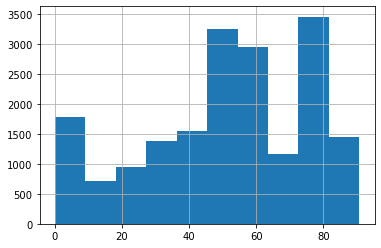

In [20]:
obd_data.speed.hist()
plt.show()

This seems like a reasonable distribution. The max is 93 mph, a bit high but lets see how long I was above 90 mph.

In [21]:
obd_data.speed.max()

90.720166

In [22]:
duration_90 = obd_data.loc[obd_data.speed > 90].index.max() - obd_data.loc[obd_data.speed > 90].index.min()
#convert milliseconds to seconds
time_sec = duration_90 * 0.001

In [23]:
time_sec

1.952

In [24]:
start = obd_data.index[0]

In [25]:
end = obd_data.index[-1]

In [26]:
duration = (end - start) * 0.001

In [27]:
duration / 3600

1.4281861111111112

12 seconds! I was certainly passing a vehicle quickly.

In [85]:
gps_data.index.values

array([  64487,   64751,   65020, ..., 5201049, 5201318, 5201731],
      dtype=int64)

Here is where I do conversions for the gps data and drop rows with no data.

In [28]:
gps_data['lat'] = gps_data['lat'].astype('float',errors='ignore')
gps_data['long'] = gps_data['long'].astype('float',errors='ignore')
gps_data['speed_kmph'] = gps_data['speed_kmph'].astype('float',errors='ignore')
gps_data['speed_kmph'] = gps_data['speed_kmph'] * 0.621371

gps_data.rename(columns={'speed_kmph':'speed_mph'},inplace=True)

#div lat and long my 1mil to get right number
gps_data['lat'] = gps_data['lat'] / 1000000
gps_data['long'] = gps_data['long'] / 1000000


gps_data = gps_data.dropna(how='all')



<ipython-input-28-43edf39e9a99>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['lat'] = gps_data['lat'].astype('float',errors='ignore')
<ipython-input-28-43edf39e9a99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_data['long'] = gps_data['long'].astype('float',errors='ignore')
<ipython-input-28-43edf39e9a99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [29]:
gps_data.loc[gps_data.utctime == '40']

,utcdate,utctime,lat,long,alt,speed_mph,n_sats
1773459,NaN,40,0.0,0.0,0,2079.728737,0


In [30]:
gps_data['utctime'][1773459]

'40'

In [50]:
from datetime import datetime

In [65]:
gps_data['utcdate'].iloc[0]

Timestamp('2021-11-19 00:00:00')

The UTC date is written once while the time is continous. I define the formats below and convert them to date time.

In [67]:
#get utc date
utc_date_format = '%d%m%y'
utc_time_format = '%H%M%S%f'

#apply formats
date = gps_data['utcdate'].iloc[0]
gps_data['utcdate'] = pd.to_datetime(gps_data['utcdate'].iloc[0],format=utc_date_format)

gps_data['utcdate'] = gps_data['utcdate'].iloc[0]

gps_data['utctime'] = pd.to_datetime(gps_data['utctime'],format=utc_time_format,errors='coerce')

In [68]:
gps_data['utcdate'].unique()

array(['2021-11-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [69]:
#get rid of the leading date for utctime
gps_data['utctime'] = pd.DatetimeIndex(gps_data['utctime']).time

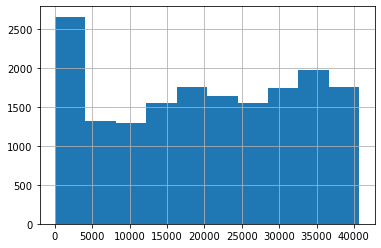

In [70]:
gps_data.speed_mph.hist()
plt.show()

I am having some trouble with the units for the units on the gps speed. I will have to look into how the receiver reports data. I started plotting the location and speed from the gps and then put it over a map.

Now, I am going to make a new folder in this directory for each car trip. The name of the folder will be the start date and time.


In [71]:
import os

In [72]:
gps_data.index[0]

64487

In [73]:
time_str = str(gps_data['utctime'][gps_data.index[0]])
hour = time_str[:2]
minute = time_str[3:5]
second = time_str[6:8]

In [74]:
second

''

In [75]:
date_str = str(gps_data['utcdate'][gps_data.index[0]])[:10]

In [76]:
folder_path = date_str + '__' + hour + '-' + minute + '-' + second

In [77]:
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

Now, save dataframes with new names.

In [78]:
gps_data.to_csv(f'{folder_path}/gps_data_{date_str}.csv')
acc.to_csv(f'{folder_path}/acc_data_{date_str}.csv')
obd_data.to_csv(f'{folder_path}/obd_data_{date_str}.csv')

Next, I would like to use reverse_geocode to find the start and end points for each trip. I think I could sort each one according to those points. Then, I would like to calculate average stats across each trip. I could calculate an average time and compare that to the time of day.

I would also like to try to plot using google maps so that I can see a whole trip.

In [79]:
#make folder without lat and long that I can upload

In [80]:
folder_path = date_str + '__' + hour + '-' + minute + '-' + second + '_sans_location'

In [81]:
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [82]:
gps_data.drop(labels=['lat','long'],axis=1,inplace=True)

KeyError: "['lat' 'long'] not found in axis"

In [83]:
gps_data.to_csv(f'{folder_path}/gps_data_{date_str}.csv')
acc.to_csv(f'{folder_path}/acc_data_{date_str}.csv')
obd_data.to_csv(f'{folder_path}/obd_data_{date_str}.csv')